# Conditional GAN

In [1]:
import torch
from torch import nn

from tqdm.auto import tqdm

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2  # normalise
    image_unflat = image_tensor.detach().cpu()  # shift the tensor to cpu
    image_grid = make_grid(image_unflat[:num_images], nrow=5)  # make grid
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  # imshow takes in H, W, C rather than C, H, W
    plt.show()

### Generator

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [4]:
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

### Discriminator

In [5]:
# For initialising discriminator, we need to know
# input channels(channels in img), and the hidden
# channels.
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


### Class Input

In [6]:
import torch.nn.functional as F

def get_one_hot_labels(labels, n_classes):
  '''
  Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
  Parameters:
      labels: tensor of labels from the dataloader, size (?)
      n_classes: the total number of classes in the dataset, an integer scalar
  '''
  return F.one_hot(labels, n_classes)

In [7]:
def combine_vectors(x, y):
  combined = torch.cat((x, y), dim=1).float()  # combine (n, noise) and (n, classes) to (n, noise+classes)
  return combined

### Training Initializations

In [8]:
mnist_shape = (1, 28, 28)
n_classes = 10

In [9]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 342734170.15it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 126578572.44it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 151295998.70it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 21648328.15it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
  generator_inp_dim = z_dim + n_classes
  discriminator_inp_dim = mnist_shape[0] + n_classes

  return generator_inp_dim, discriminator_inp_dim

In [11]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

### Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 2.908184336423874, discriminator loss: 0.12939569706097245


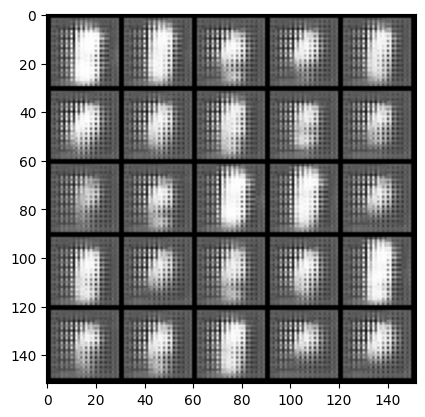

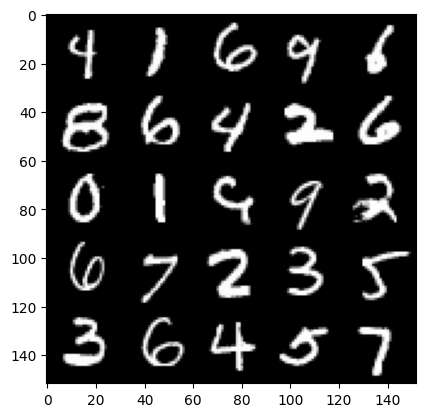

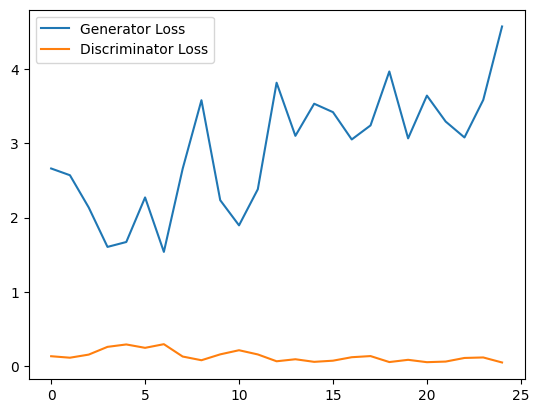

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 4.317034721374512, discriminator loss: 0.06345934161916375


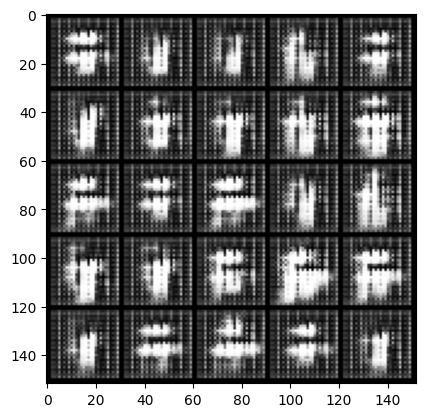

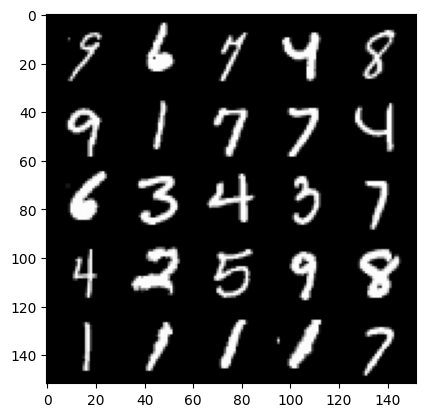

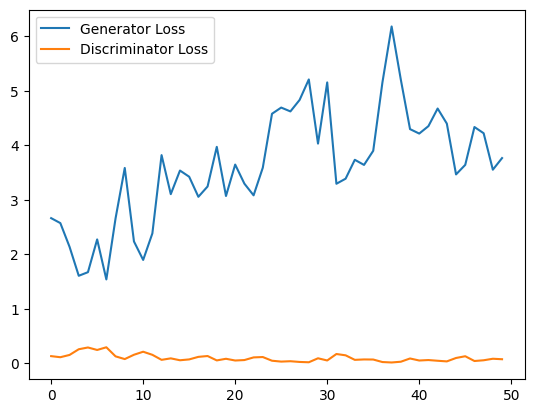

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 3.791149251461029, discriminator loss: 0.06610892517305911


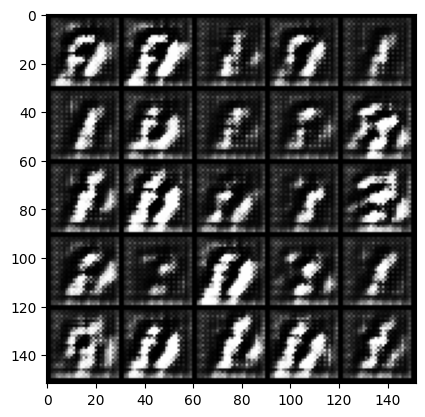

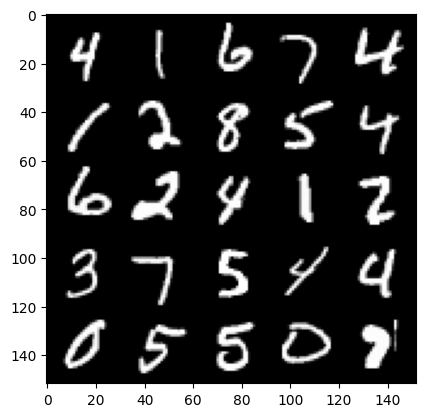

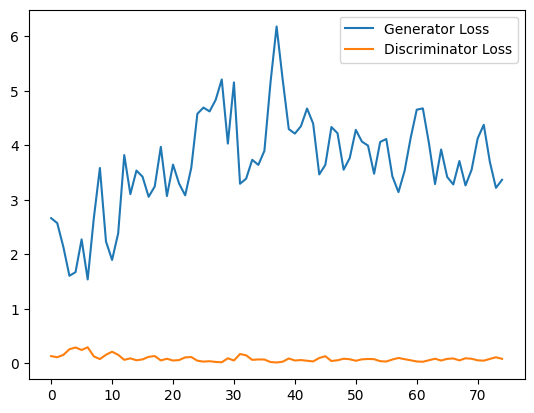

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 3.4894695215225218, discriminator loss: 0.12340443565696478


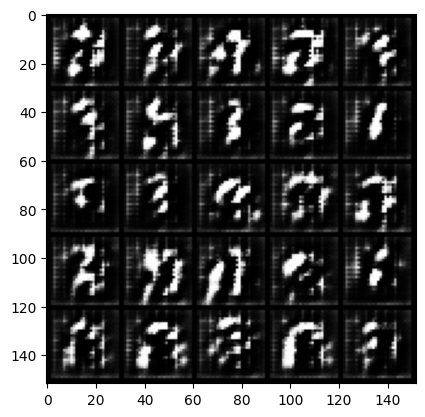

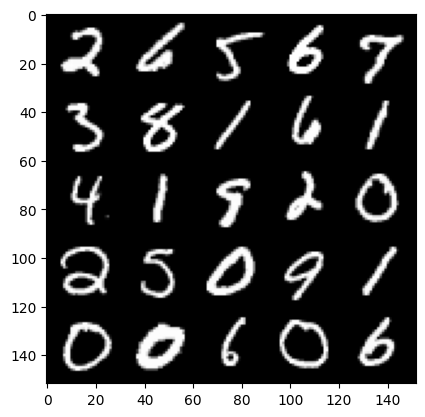

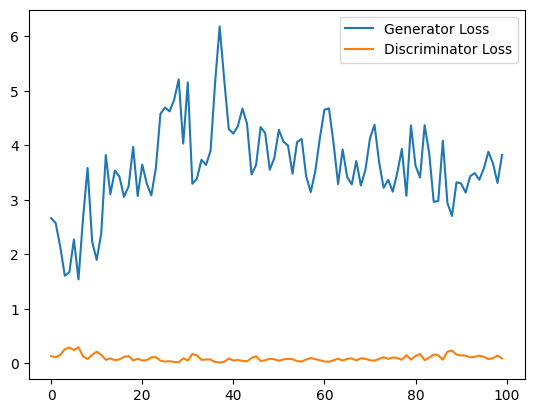

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 2.745858943939209, discriminator loss: 0.19850564204156398


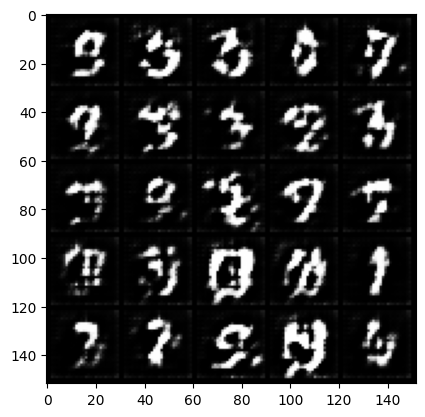

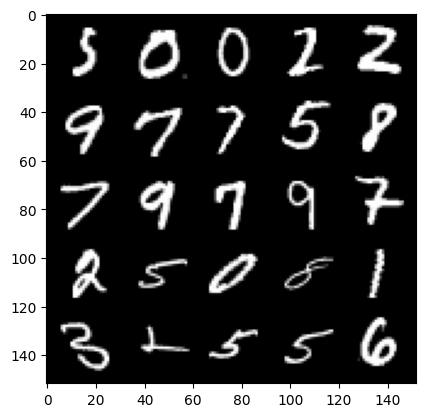

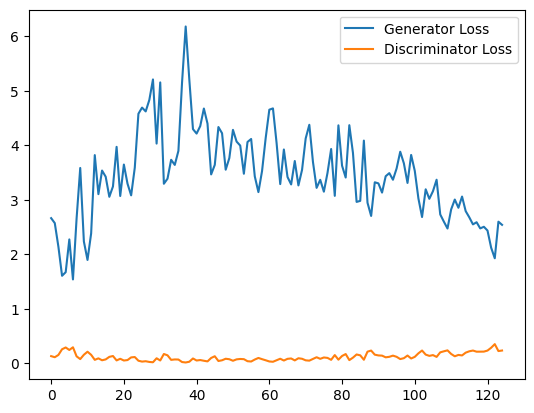

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 2.2892871599197386, discriminator loss: 0.30080440679192544


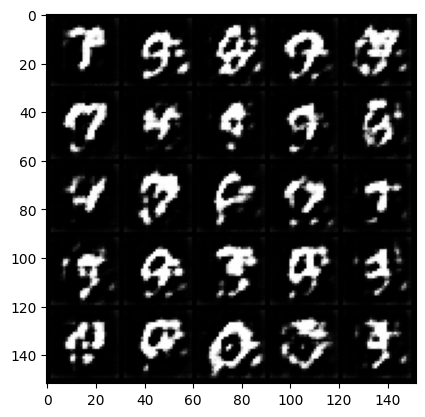

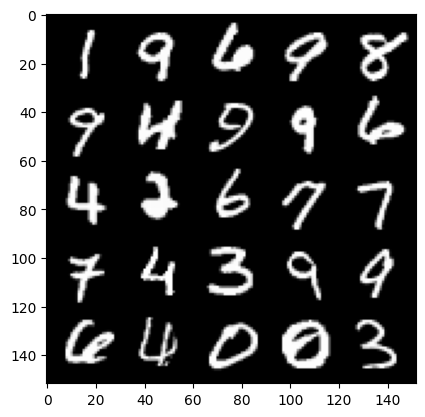

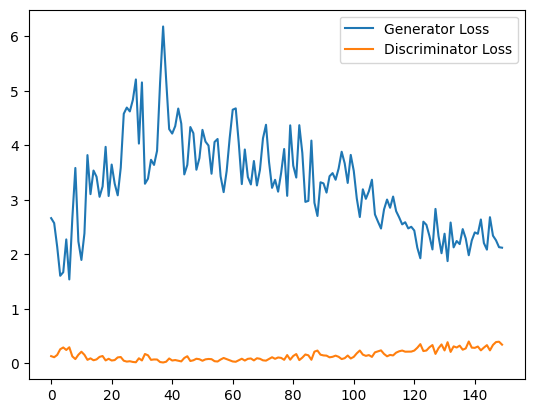

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 2.1700897331237794, discriminator loss: 0.3443061834871769


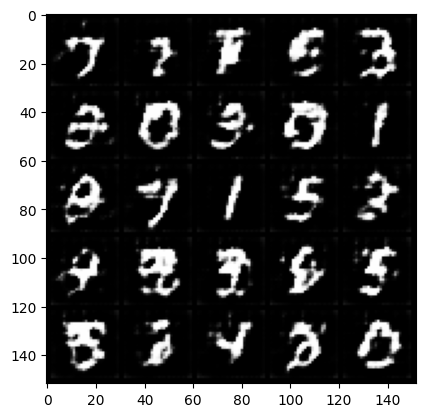

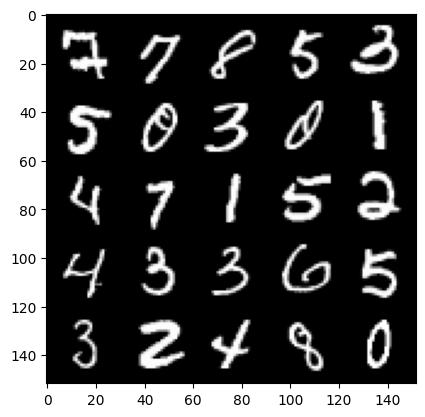

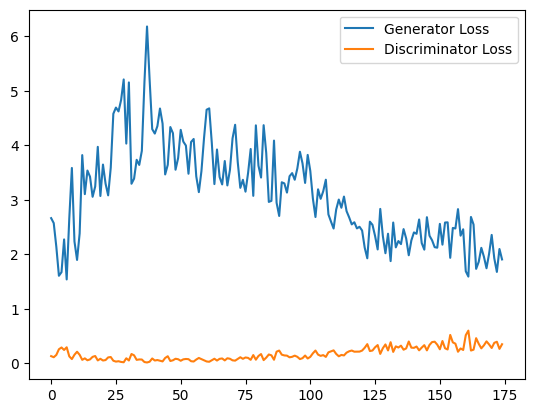

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 1.9265143686532975, discriminator loss: 0.3564622150659561


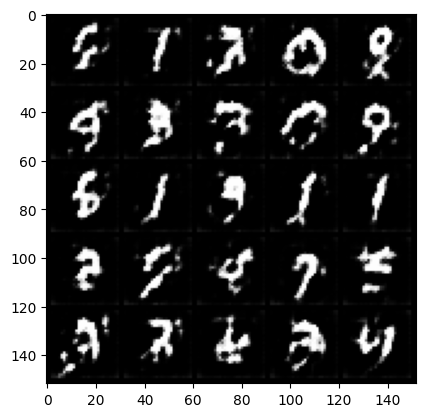

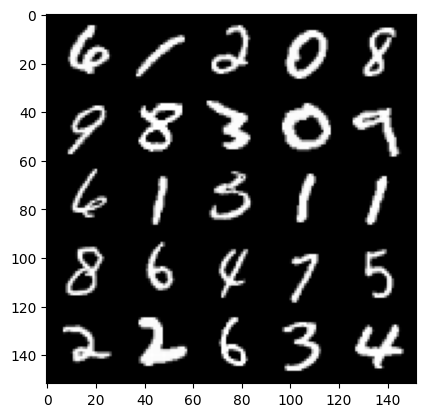

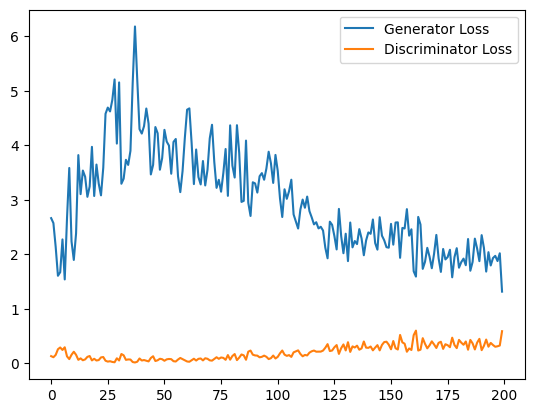

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 1.9593857247829438, discriminator loss: 0.3472505943477154


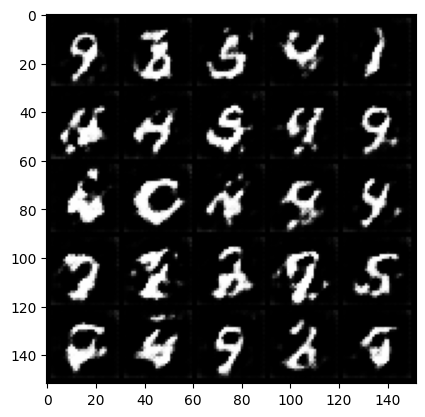

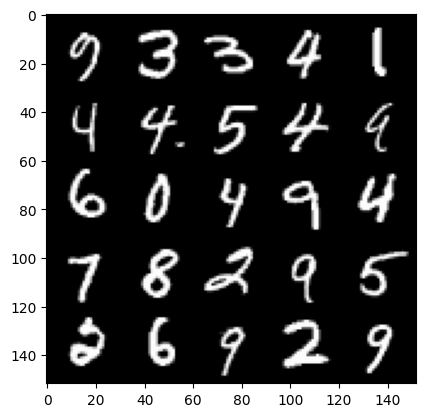

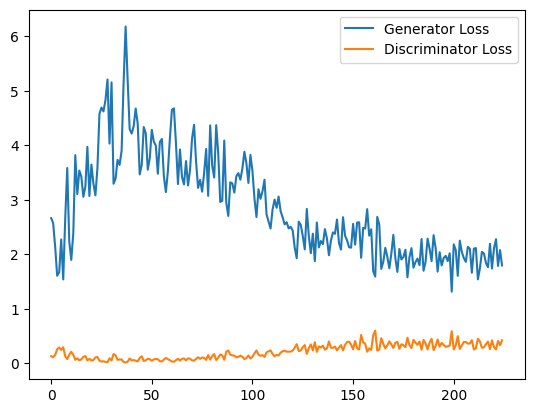

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 1.896747658252716, discriminator loss: 0.34874128475785254


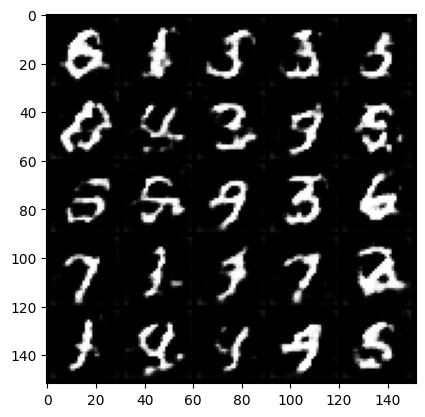

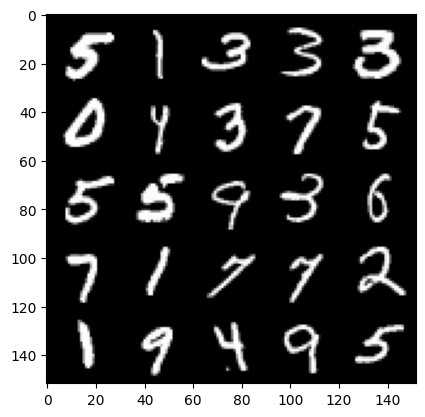

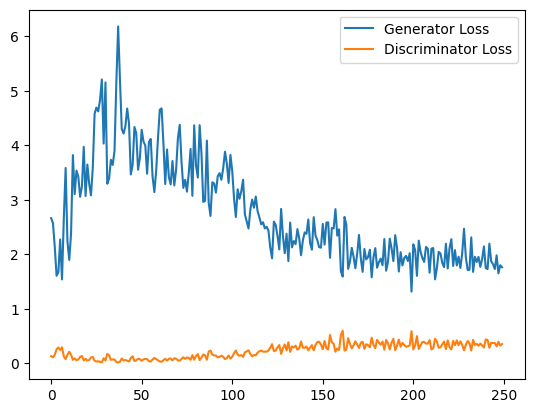

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 1.8061881692409516, discriminator loss: 0.3679382257759571


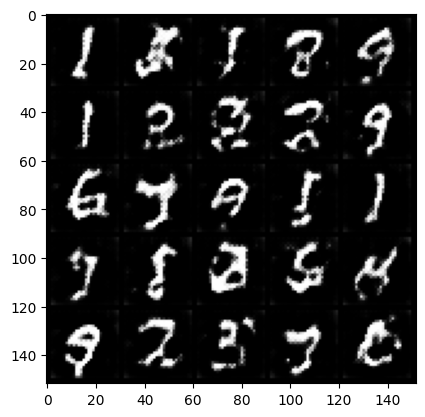

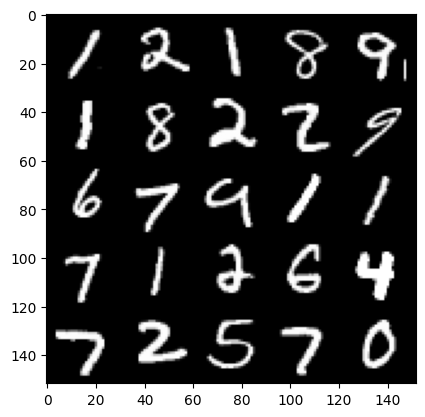

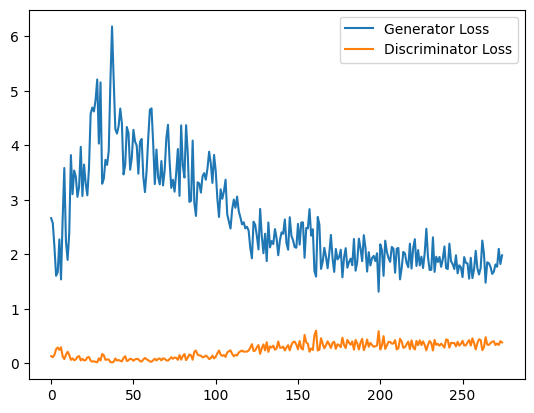

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.8102119448184968, discriminator loss: 0.4008337555229664


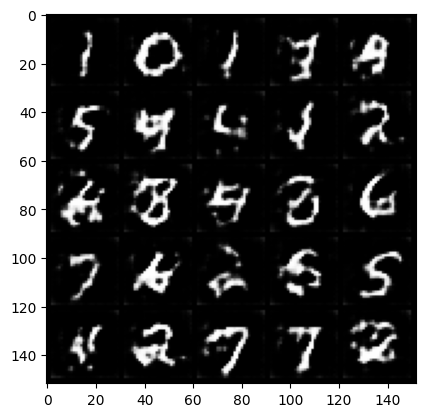

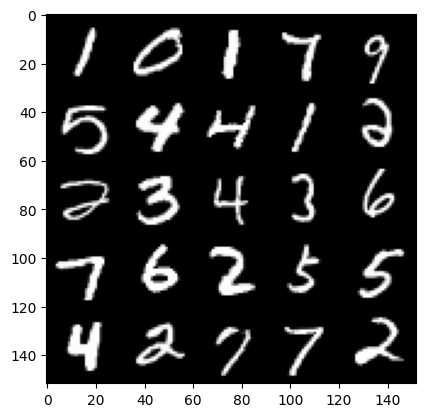

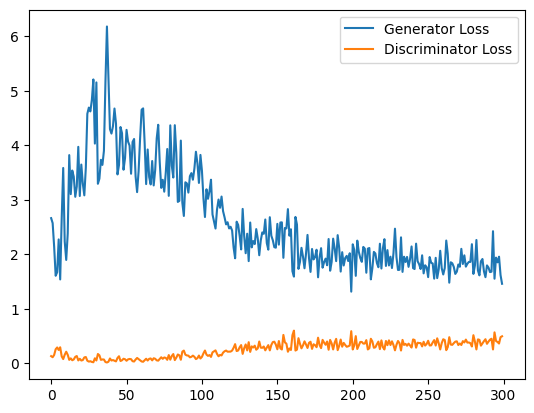

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.7099490563869477, discriminator loss: 0.4118161492049694


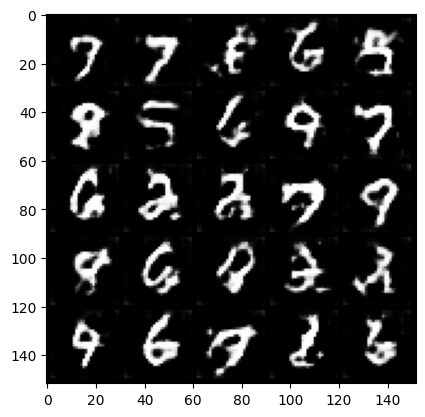

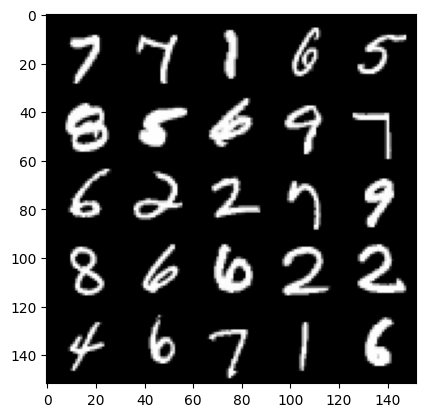

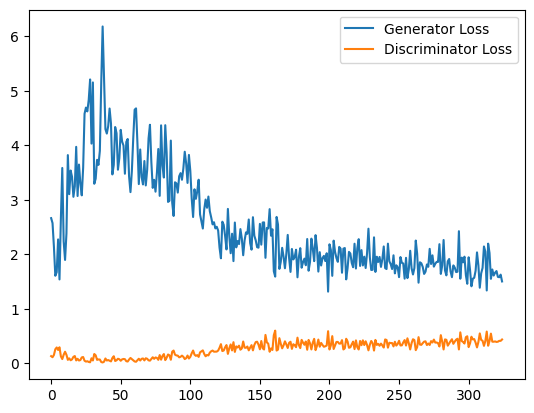

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.5268338726758957, discriminator loss: 0.43292347392439845


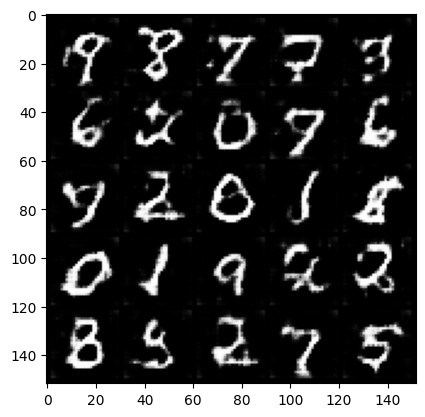

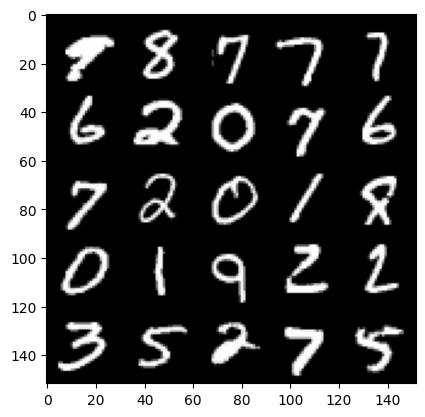

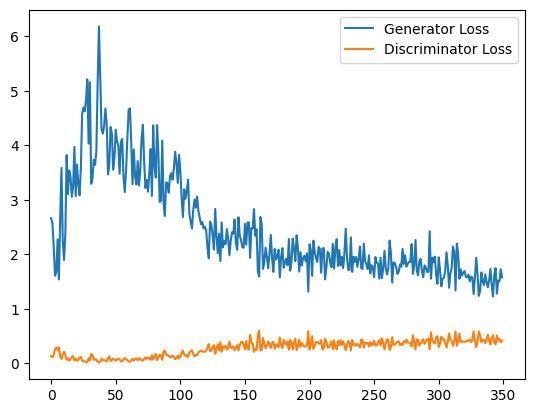

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.511022236943245, discriminator loss: 0.46076132702827455


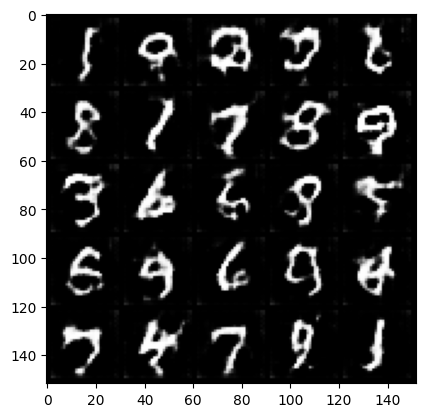

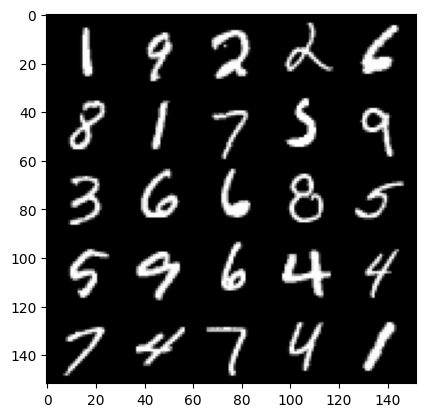

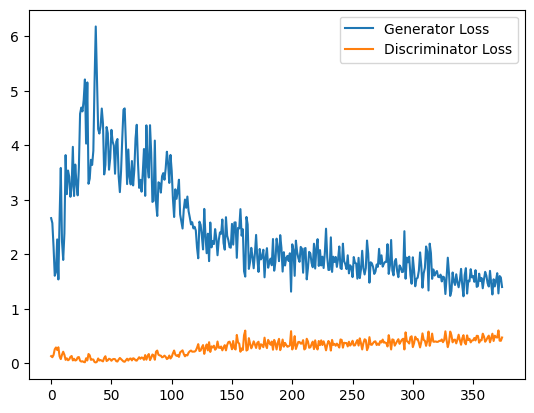

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.4711057962179184, discriminator loss: 0.4749529582858086


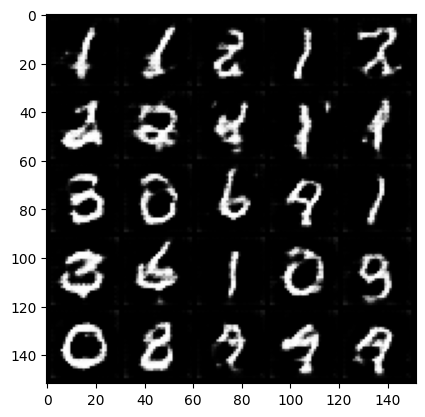

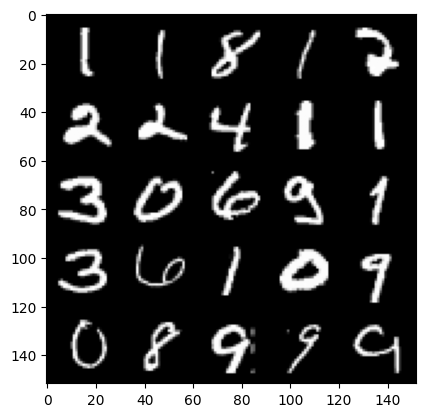

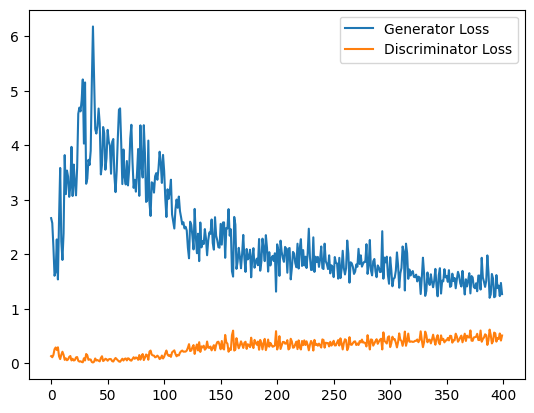

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.3881599671840668, discriminator loss: 0.48832618337869643


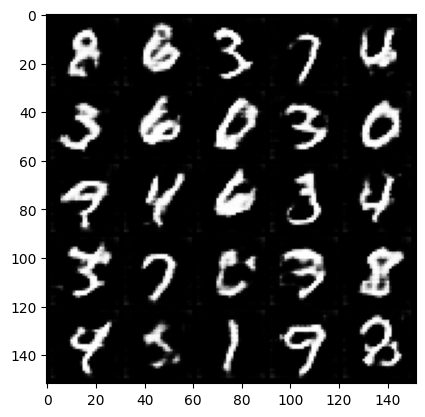

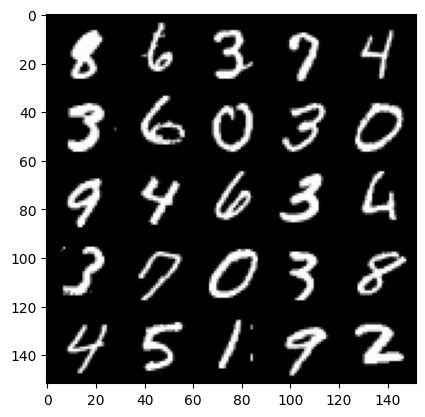

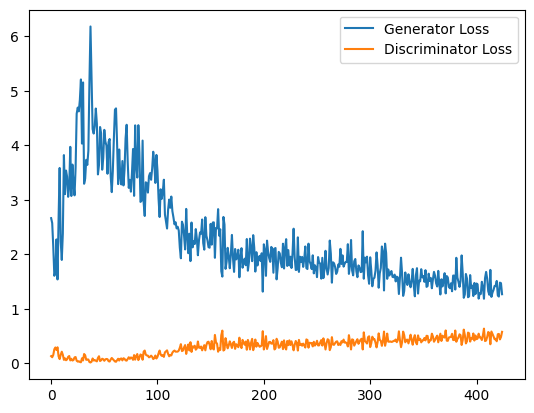

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
  for real, labels in tqdm(dataloader):
    cur_batch_size =  len(real)
    real = real.to(device)

    one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)  # e.g., (128, 10)
    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

    # Update the discriminator
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)

    fake_image_and_labels = torch.cat((fake, image_one_hot_labels), dim=1)
    real_image_and_labels = torch.cat((real, image_one_hot_labels), dim=1)

    disc_fake_pred = disc(fake_image_and_labels)
    disc_real_pred = disc(real_image_and_labels)

    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    # Keep track of the average discriminator loss
    discriminator_losses += [disc_loss.item()]

    # Update Generator
    # Zero out the generator gradients
    gen_opt.zero_grad()

    fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
    disc_fake_pred = disc(fake_image_and_labels)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Keep track of the generator losses
    generator_losses += [gen_loss.item()]

    if cur_step % display_step == 0 and cur_step > 0:
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        disc_mean = sum(discriminator_losses[-display_step:]) / display_step
        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
        show_tensor_images(fake)
        show_tensor_images(real)
        step_bins = 20
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
        )
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Discriminator Loss"
        )
        plt.legend()
        plt.show()

    cur_step += 1
